# <center> cs231. Assignment 2.

Goal is to build convolutional neural network with linear layers to work on CIFAR-10 dataset and reach at least $70\%$ accuracy on test set. This is a part where I use PyTorch for this.

## Importing libs

Load all the necessary libs, including my scripts for training and visualizations.

In [52]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
import os
import glob
import pickle

import gc

import copy

# ================================================

if not '..' in sys.path:
    sys.path = ['..'] + sys.path

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from albumentations import Compose, OneOf, Flip, Rotate, Normalize
from albumentations.pytorch import ToTensor

from _cs231n.torch_utils import *
from _cs231n.metrics import accuracy, confusion_matrix

# ================================================

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# ================================================

PATH_TO_DATA = '../data/cifar-10-batches-py'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading & visualizing dataset

Dataset has been previously downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). There is a script `get_data.sh` in `assignment1` folder for this. Dataset is already split into train and test.

We will also normalize dataset on each of 3 channels separately to zero mean and unit variance.

In [2]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0)
X_train0 = X_train0.reshape(-1, 3, 32, 32)
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data']
    X_test0 = X_test0.reshape(-1, 3, 32, 32)
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================
# Load images categories

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]
    
# ================================================
# Normalize dataset separately on each channel
    
X_mean = (X_train0.astype(np.float64)/255).mean(axis=(0, 2, 3))
X_std = (X_train0.astype(np.float64)/255).std(axis=(0, 2, 3))

X_train_norm = ((X_train0.astype(np.float64)/255) - X_mean[None, :, None, None])/X_std[None, :, None, None]
X_test_norm = ((X_test0.astype(np.float64)/255) - X_mean[None, :, None, None])/X_std[None, :, None, None]

Training data shape: 50000x3
Test data shape: 10000x3


Let's visualize dataset to see what we're dealing with. There are 10 categories of images, we will display several pics from each category.

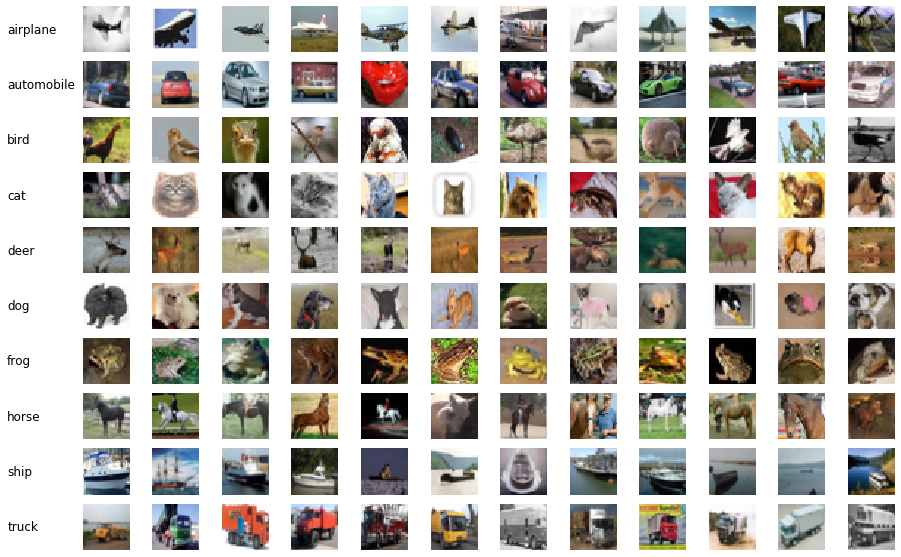

In [3]:
n_imgs = 12
labels = np.unique(y_train0)

fig0, axs = plt.subplots(nrows=len(labels), ncols=n_imgs + 1, figsize=(16, len(labels)))
for (xlabel, xcat, xaxs) in zip(labels, categories, axs):
    xaxs[0].text(0, 0.5, xcat, fontsize=12, va='center')
    xaxs[0].axis('off')
    idxs = np.random.choice(np.argwhere(y_train0 == xlabel).ravel(), n_imgs, replace=False)
    
    for (idx, xax) in zip(idxs, xaxs[1:]):
        xax.imshow(X_train0[idx].transpose((1, 2, 0)))
        xax.set_aspect('equal')
        xax.axis('off')

Ok, due to low resolution some pics are pretty hard to get, even for human eye. Hope that neural net will do better than me.

As usual, we pick some data randomly from training set to serve as validation data.

In [4]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## Setting up PyTorch

I will use my GPU to work on this project.

In [5]:
assert torch.cuda.is_available()
GPU = torch.device('cuda: 0')

Although we're working with images here - we won't be using any image-specific tools and data augmentations, so simple `TensorDataset` would be enough. One note: Torch prefers images to have dimensions as ($B$, $C$, $H$, $W$), so we need to transpose axes a little.

In [6]:
X_train_norm_torch = torch.from_numpy(X_train_norm).type(torch.float)
y_train_torch = torch.from_numpy(y_train0).type(torch.LongTensor)
X_test_norm_torch = torch.from_numpy(X_test_norm).type(torch.float)
y_test_torch = torch.from_numpy(np.array(y_test0)).type(torch.LongTensor)

tiny_dset = TensorDataset(X_train_norm_torch[train_idxs[:100]], y_train_torch[train_idxs[:100]])
train_dset = TensorDataset(X_train_norm_torch[train_idxs], y_train_torch[train_idxs])
val_dset = TensorDataset(X_train_norm_torch[val_idxs], y_train_torch[val_idxs])
test_dset = TensorDataset(X_test_norm_torch, y_test_torch)

Prepare data loaders.

In [7]:
train_loader = DataLoader(train_dset, batch_size=128, 
                          sampler=RandomSampler(train_dset))
val_loader = DataLoader(val_dset, batch_size=128, 
                        sampler=RandomSampler(val_dset))
test_loader = DataLoader(test_dset, batch_size=128, 
                         sampler=SequentialSampler(test_dset))

Helper class that we use to pass from convolutional layers to fully-connected. All it does is just flattening tensor into 2 dimensions: batch and features.

In [8]:
class Flattener(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X.view(X.shape[0], -1)

## Training torch models

Here we build and test several models, trying to reach our goal - get $70\%$ accuracy on test dataset.

### Torch model 1.

As usual, first model is very simple. Just one 3x3 convolution followed by max pooling, and then we flatten and pass it to two-layers linear classificator. Also, BatchNorms and Dropouts are added to reduce overfitting.

In [9]:
model_torch1 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), 
    # 32 x 32 x 32
    nn.MaxPool2d(kernel_size=5, stride=3), 
    # 32 x 10 x 10
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=32), 
    nn.Dropout(p=0.2), 
    Flattener(), 
    # 3200
    nn.Linear(in_features=3200, out_features=256, bias=False), 
    # 256
    nn.BatchNorm1d(num_features=256), 
    nn.Dropout(p=0.5),
    nn.ReLU(), 
    nn.Linear(in_features=256, out_features=10)
    # 10
)

Moving model to GPU.

In [10]:
model_torch1.type(torch.cuda.FloatTensor)
model_torch1.to(GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Flattener()
  (6): Linear(in_features=3200, out_features=256, bias=False)
  (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=10, bias=True)
)

#### Training

Let's check how model initializes. We expect to see accuracy of around $10\%$ and log-loss of around $\log{10} \approx 2.30$.

In [11]:
init_check = initial_model_check(model_torch1, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss = [init_check[0]]
val_loss = [init_check[1]]
val_acc = [init_check[2]]

Model loss on train set: 2.302
Model loss on validation set: 2.302
Model metric on validation set set: 0.11560


Very good.

I intentionally skip overfitting to small dataset here. It does overfit though, I tried it.

All right. Initialize all the necessary components: loss function, optimizer and learning rate scheduler and get on with training. We will train for 24 epochs, gradually decreasing learning rate.

In [12]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch1.parameters(), lr=1e-2, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.95, step_size=3)

tr_res = train_torch(model_torch1, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     early_stopping=True, early_stopping_rounds=3, 
                     delay=0)

tr_loss += tr_res[0]
val_loss += tr_res[1]
val_acc += tr_res[2]


--------------------------------
Epoch 1/24
--------------------------------


Training pass over.
Training loss: 1.4783368509292603
Validation loss: 1.2683094890594482
Validation metric: 0.55528

--------------------------------
Epoch 2/24
--------------------------------


Training pass over.
Training loss: 1.3560483875274658
Validation loss: 1.2237657172012328
Validation metric: 0.5736

--------------------------------
Epoch 3/24
--------------------------------


Training pass over.
Training loss: 1.3413131619008383
Validation loss: 1.2331328963470458
No improvement on validation for 1 epochs
Validation metric: 0.5556

--------------------------------
Epoch 4/24
--------------------------------


Training pass over.
Training loss: 1.3171620965067545
Validation loss: 1.203163826560974
Validation metric: 0.56912

--------------------------------
Epoch 5/24
--------------------------------


Training pass over.
Training loss: 1.311298968594869
Validation loss: 1.1663459879302978
Validation metric: 0.59328

--------------------------------
Epoch 6/24
--------------------------------


Training pass over.
Training loss: 1.3134128400039673
Validation loss: 1.208988288345337
No improvement on validation for 1 epochs
Validation metric: 0.57848

--------------------------------
Epoch 7/24
--------------------------------


Training pass over.
Training loss: 1.299558801574707
Validation loss: 1.1689502085113526
No improvement on validation for 2 epochs
Validation metric: 0.58656

--------------------------------
Epoch 8/24
--------------------------------


Training pass over.
Training loss: 1.2986560340627034
Validation loss: 1.146725412864685
Validation metric: 0.60896

--------------------------------
Epoch 9/24
--------------------------------


Training pass over.
Training loss: 1.2919245614496866
Validation loss: 1.184124282875061
No improvement on validation for 2 epochs
Validation metric: 0.5712

--------------------------------
Epoch 10/24
--------------------------------


Training pass over.
Training loss: 1.280640340118408
Validation loss: 1.1722082637786866
No improvement on validation for 3 epochs
Invoking early stopping
Validation metric: 0.58744


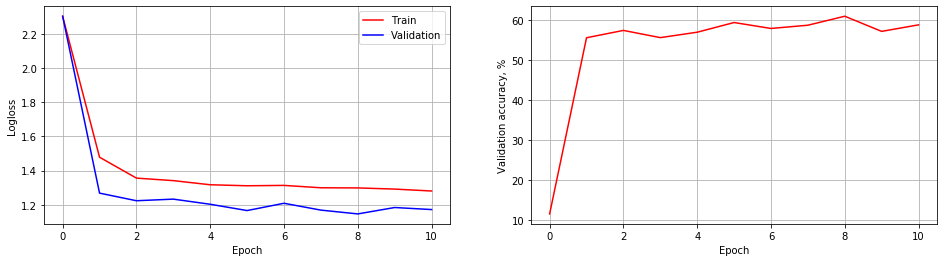

In [13]:
visualize_training(tr_loss, val_loss, val_acc)

The curves look very good - I see no ovefitting, and we got above $70\%$ accuracy on validation set.

#### Saving/loading model

In [15]:
torch.save(model_torch1.state_dict(), os.path.join('.', 'model_torch1_weights'))
#model_torch1.load_state_dict(torch.load(os.path.join('.', 'model_torch1_weights')))

#### Performance analysis

Let's analyze our model performance a little. Accuracy is very intuitive, but unfortunately not very informative metric. It takes into account only hard predictions (class with largest probability), but what if out model is not sure of its prediction? Let's see how probability of selected class is distributed depending on whether our model is correct or not. And also see how it performs on test dataset.

Test set accuracy: 60.170%


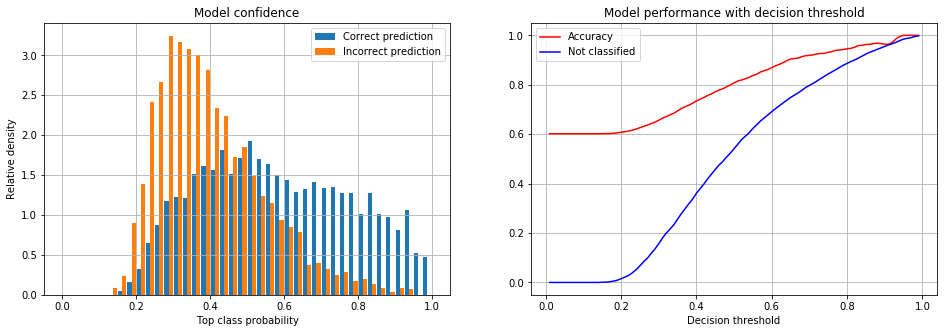

In [24]:
predX, gt, _ = predict_torch(model_torch1, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.3f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

Aha. So, our model tends to be pretty sure when it is incorrect, and not so sure when it is right. Second graph shows how our accuracy increases when we employ desicion threshold - we take no decision if largest class probability is below certain number.

Let's see where our model is wrong the most.

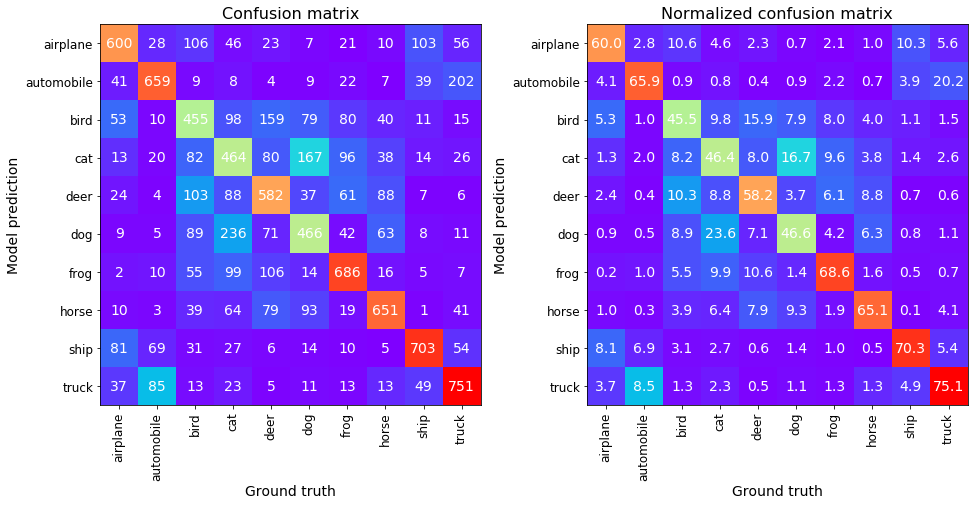

In [25]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

So, most confused classes are `cat` and `dog`, and also `bird` and `deer` are among least correctly classified classes. How do these incorrect predictions might look?

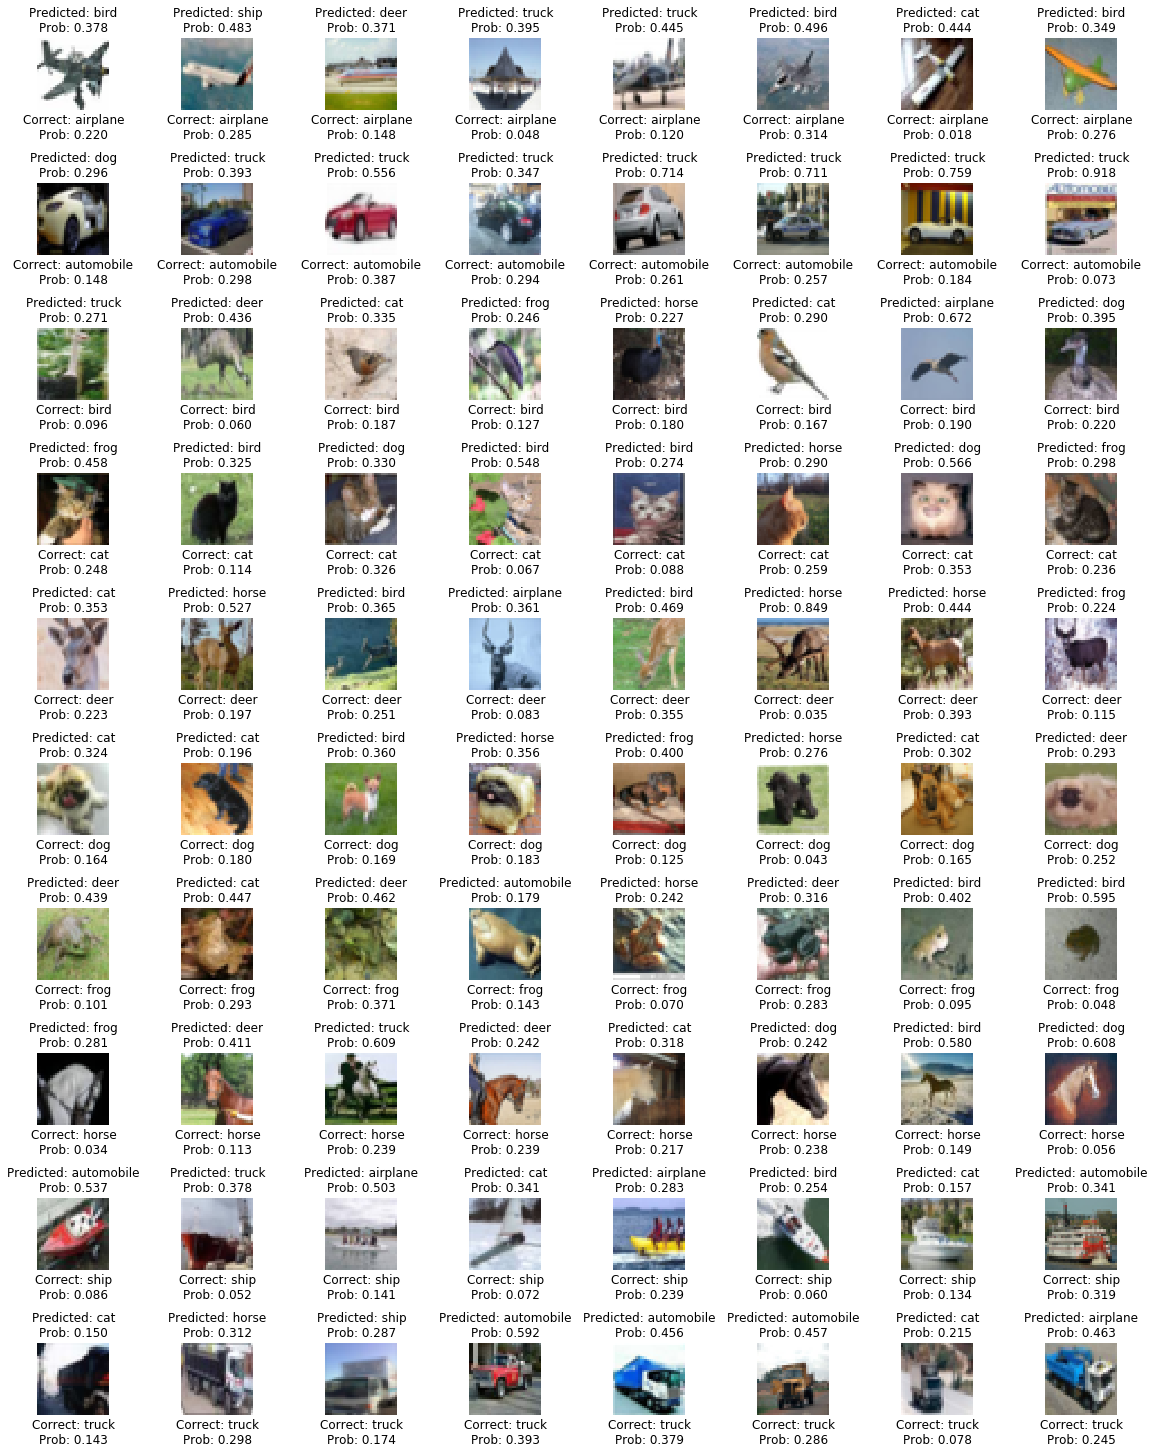

In [26]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 2.

Ok, our simple model performed quite well, but let's complicate things a little. Add one more convolution layer and increase number of channels.

In [34]:
model_torch2 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=0), 
    # 64 x 28 x 28
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 64 x 14 x 14
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=64), 
    nn.Dropout(p=0.2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0), 
    # 128 x 10 x 10
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 128 x 5 x 5
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=128), 
    nn.Dropout(p=0.2), 
    nn.AvgPool2d(kernel_size=5), 
    # 128 x 1 x 1
    Flattener(), 
    # 128
    nn.Linear(in_features=128, out_features=32, bias=False), 
    # 32
    nn.ReLU(), 
    nn.BatchNorm1d(num_features=32), 
    nn.Dropout(p=0.5), 
    nn.Linear(in_features=32, out_features=10)
    # 10
)

Moving model to GPU.

In [35]:
model_torch2.type(torch.cuda.FloatTensor)
model_torch2.to(GPU)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): ReLU()
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.2)
  (10): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (11): Flattener()
  (12): Linear(in_features=128, out_features=32, bias=False)
  (13): ReLU()
  (14): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.5)
  (16): Linear(in_features=32, out_features=10, bias=True)
)

#### Training

In [36]:
init_check = initial_model_check(model_torch2, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss = [init_check[0]]
val_loss = [init_check[1]]
val_acc = [init_check[2]]

Model loss on train set: 2.308
Model loss on validation set: 2.308
Model metric on validation set set: 0.10336


In [37]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch2.parameters(), lr=1e-3, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.8, step_size=3)

tr_res = train_torch(model_torch2, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     early_stopping=True, early_stopping_rounds=4, 
                     delay=0)

tr_loss += tr_res[0]
val_loss += tr_res[1]
val_acc += tr_res[2]


--------------------------------
Epoch 1/24
--------------------------------


Training pass over.
Training loss: 1.7617574058914185
Validation loss: 1.4020670470428467
Validation metric: 0.50528

--------------------------------
Epoch 2/24
--------------------------------


Training pass over.
Training loss: 1.378200319773356
Validation loss: 1.1700590914535522
Validation metric: 0.59032

--------------------------------
Epoch 3/24
--------------------------------


Training pass over.
Training loss: 1.2131701473236085
Validation loss: 1.0616053701782227
Validation metric: 0.63344

--------------------------------
Epoch 4/24
--------------------------------


Training pass over.
Training loss: 1.1069337027486166
Validation loss: 0.9656313598060607
Validation metric: 0.66064

--------------------------------
Epoch 5/24
--------------------------------


Training pass over.
Training loss: 1.0412168533579509
Validation loss: 0.9294465514945984
Validation metric: 0.67656

--------------------------------
Epoch 6/24
--------------------------------


Training pass over.
Training loss: 0.9942271103159587
Validation loss: 0.9033938232803345
Validation metric: 0.67848

--------------------------------
Epoch 7/24
--------------------------------


Training pass over.
Training loss: 0.9304019565455118
Validation loss: 0.8400279480934143
Validation metric: 0.71

--------------------------------
Epoch 8/24
--------------------------------


Training pass over.
Training loss: 0.9047798510932923
Validation loss: 0.822515205039978
Validation metric: 0.71728

--------------------------------
Epoch 9/24
--------------------------------


Training pass over.
Training loss: 0.8680513736025492
Validation loss: 0.7822206239128113
Validation metric: 0.73272

--------------------------------
Epoch 10/24
--------------------------------


Training pass over.
Training loss: 0.833640069363912
Validation loss: 0.7611202568435669
Validation metric: 0.74192

--------------------------------
Epoch 11/24
--------------------------------


Training pass over.
Training loss: 0.8095176272964477
Validation loss: 0.7812379075622559
No improvement on validation for 1 epochs
Validation metric: 0.73016

--------------------------------
Epoch 12/24
--------------------------------


Training pass over.
Training loss: 0.7992241788609823
Validation loss: 0.7437940754508973
Validation metric: 0.74192

--------------------------------
Epoch 13/24
--------------------------------


Training pass over.
Training loss: 0.7552272431755066
Validation loss: 0.7247354930114747
Validation metric: 0.75352

--------------------------------
Epoch 14/24
--------------------------------


Training pass over.
Training loss: 0.7411219954617818
Validation loss: 0.7343579307556153
No improvement on validation for 1 epochs
Validation metric: 0.75376

--------------------------------
Epoch 15/24
--------------------------------


Training pass over.
Training loss: 0.7264132145754496
Validation loss: 0.7090545022392273
Validation metric: 0.758

--------------------------------
Epoch 16/24
--------------------------------


Training pass over.
Training loss: 0.6888987787946065
Validation loss: 0.6923984870910644
Validation metric: 0.76528

--------------------------------
Epoch 17/24
--------------------------------


Training pass over.
Training loss: 0.6858231736119588
Validation loss: 0.6903072355270385
Validation metric: 0.76312

--------------------------------
Epoch 18/24
--------------------------------


Training pass over.
Training loss: 0.6729840204493205
Validation loss: 0.7044866725158692
No improvement on validation for 1 epochs
Validation metric: 0.75768

--------------------------------
Epoch 19/24
--------------------------------


Training pass over.
Training loss: 0.653937675221761
Validation loss: 0.6841369731330872
Validation metric: 0.76976

--------------------------------
Epoch 20/24
--------------------------------


Training pass over.
Training loss: 0.6363221804745992
Validation loss: 0.6774411269569397
Validation metric: 0.76784

--------------------------------
Epoch 21/24
--------------------------------


Training pass over.
Training loss: 0.6246069854799906
Validation loss: 0.6701781488990783
Validation metric: 0.77504

--------------------------------
Epoch 22/24
--------------------------------


Training pass over.
Training loss: 0.6088806817563375
Validation loss: 0.6684220988845825
Validation metric: 0.77608

--------------------------------
Epoch 23/24
--------------------------------


Training pass over.
Training loss: 0.6018837850379943
Validation loss: 0.6650568495368957
Validation metric: 0.77288

--------------------------------
Epoch 24/24
--------------------------------


Training pass over.
Training loss: 0.5897405949211121
Validation loss: 0.6662447986984253
No improvement on validation for 1 epochs
Validation metric: 0.77608


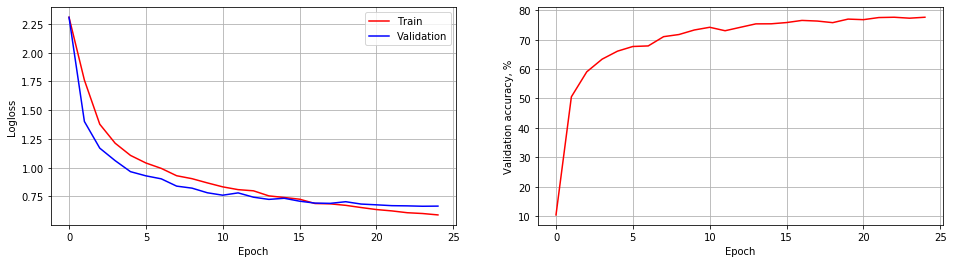

In [38]:
visualize_training(tr_loss, val_loss, val_acc)

#### Saving/loading model

In [39]:
torch.save(model_torch2.state_dict(), os.path.join('.', 'model_torch2_weights'))
#model_torch2.load_state_dict(torch.load(os.path.join('.', 'model_torch2_weights')))

#### Performance analysis

Test set accuracy: 76.8%


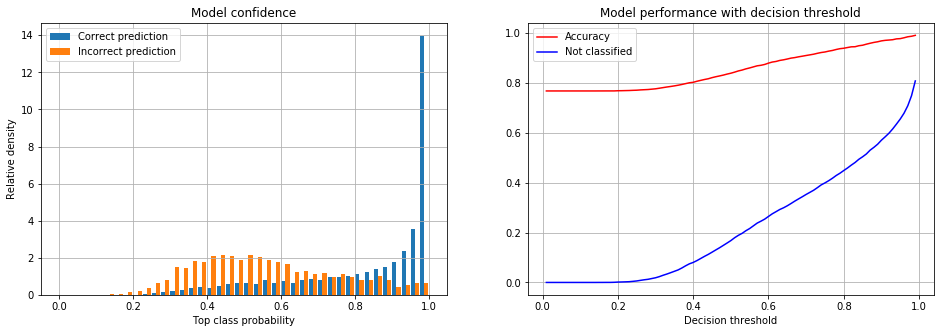

In [40]:
predX, gt, _ = predict_torch(model_torch2, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

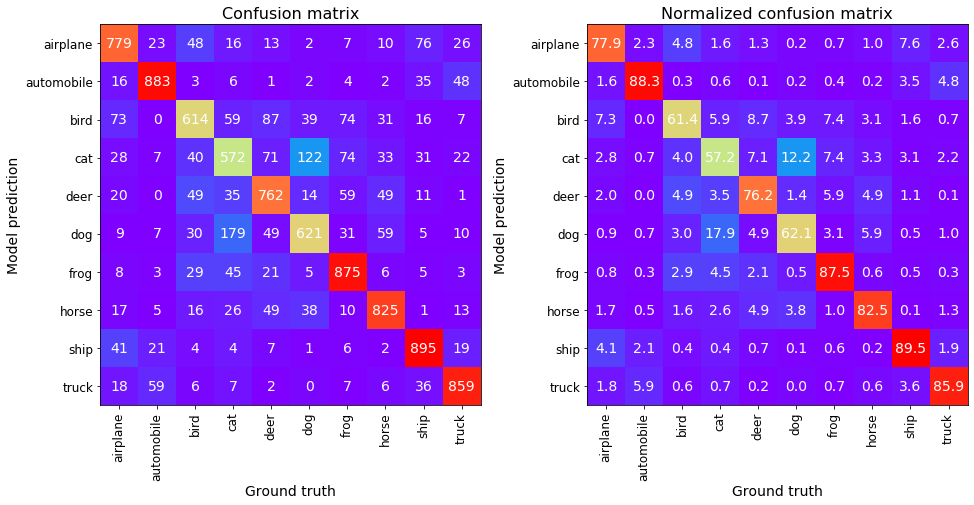

In [41]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

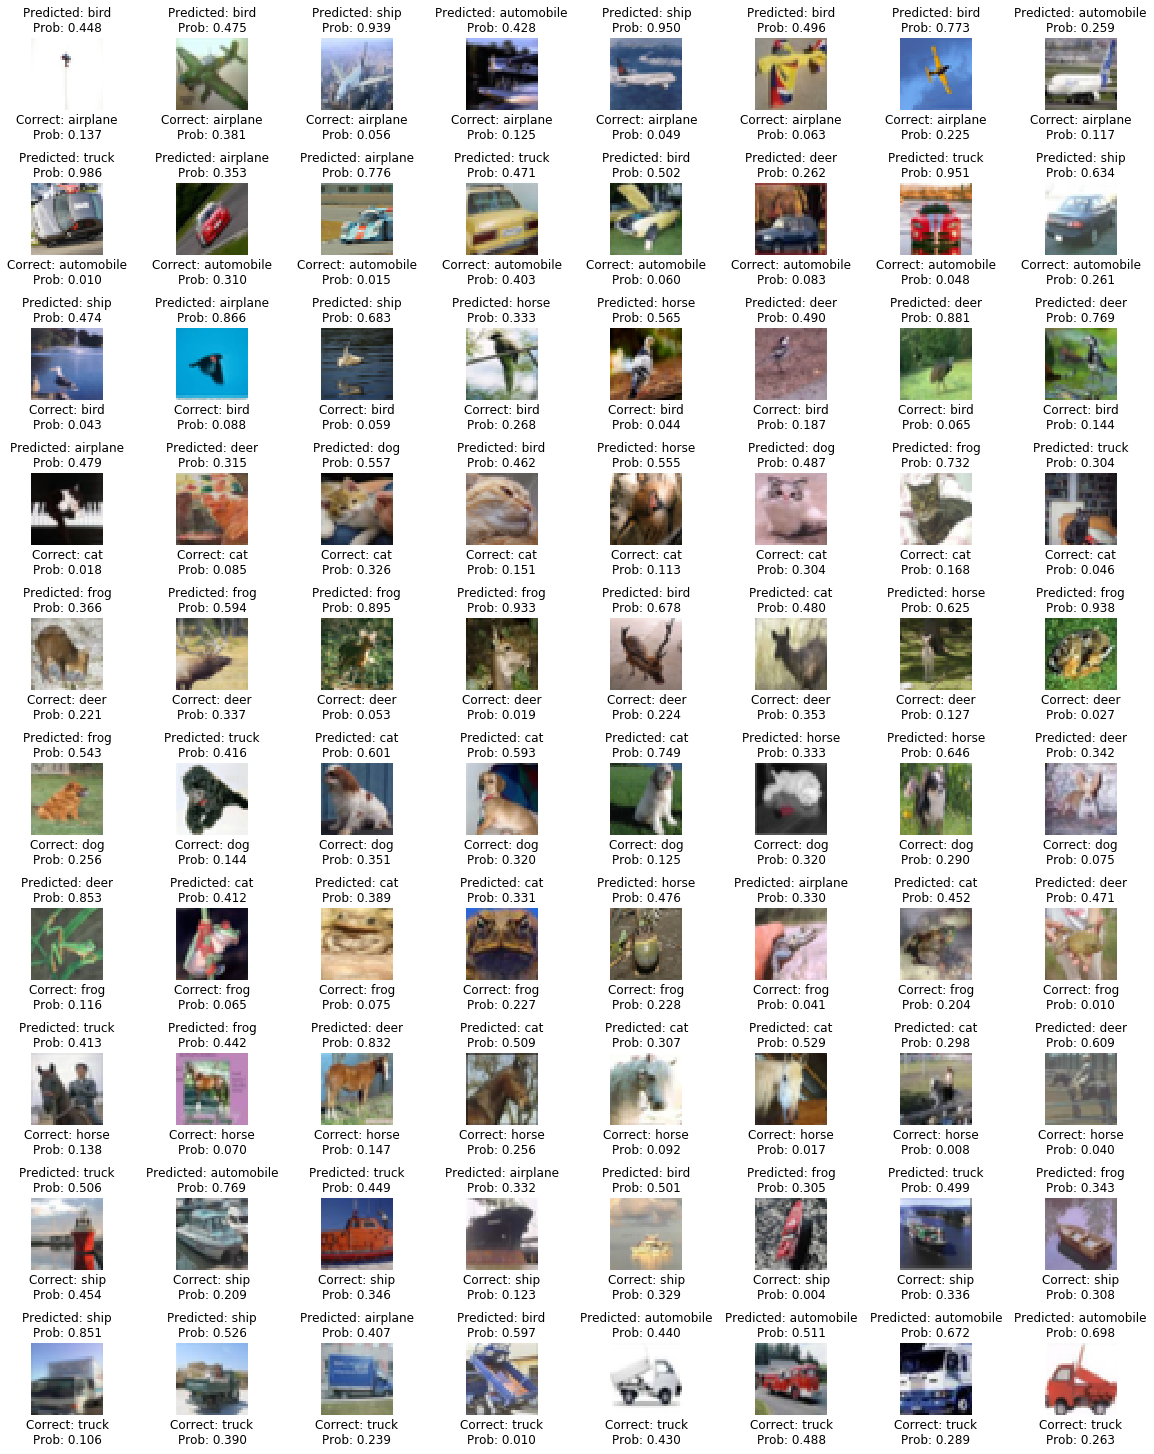

In [42]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 3.

In [43]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, kernel_size=3):
        super().__init__()
        
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, 
                      padding=(kernel_size - 1)//2, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(out_channels)
        )
        
        if in_channels == out_channels:
            self.walkaround = nn.BatchNorm2d(in_channels)
        else:
            self.walkaround = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), 
                nn.BatchNorm2d(out_channels)
            )
            
        self.relu_out = nn.ReLU(True)
        

    def forward(self, X):
        identity = self.walkaround(X)
        out = self.convblock(X)
        
        out += identity
        out = self.relu_out(out)
        
        return out

In [44]:
class TinyResNet(nn.Module):
    def __init__(self, res_blocks=1, res_kernel=3, downsampling='maxpool', 
                 start_channels=64, out_channels_mult=2, hid_channels_mult=1, 
                 drop_conv=None, drop_linear=None):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, start_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(start_channels), 
            nn.ReLU(True)
        )
        
        # ----------------
        
        cur_sz = 32
        cur_channels = start_channels
        ib = 1
        
        while cur_sz > 1:
            self.add_module(f'resblock{ib}', nn.Sequential(
                Bottleneck(cur_channels, int(cur_channels*out_channels_mult), 
                           int(cur_channels*hid_channels_mult), res_kernel), 
                *[
                    Bottleneck(int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult*hid_channels_mult), 
                               res_kernel) for ix in range(res_blocks - 1)
                ]
            ))
            cur_channels = int(cur_channels*out_channels_mult)
            
            # --------------------------------
            
            if downsampling == 'maxpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.MaxPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'avgpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.AvgPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'conv':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.Conv2d(cur_channels, cur_channels, kernel_size=2, stride=2, bias=False), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            else:
                raise ValueError(f'Unknown downsampling code {downsampling}')
            cur_sz //= 2
            
            # --------------------------------
            
            if drop_conv:
                self.add_module(f'dropout{ib}', nn.Dropout(drop_conv))
            ib += 1
            
        # ----------------
        
        self.add_module('flattener', Flattener())
        features_mid = int(2**np.round(np.log2(10*cur_channels)/2))
                                
        if drop_linear:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Dropout(drop_linear), 
                nn.Linear(features_mid, 10)
            ))
        else:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Linear(features_mid, 10)
            ))

    def forward(self, X):
        out = X

        for xmodule in self.children():
            out = xmodule(out)

        return out

In [45]:
model_torch3 = TinyResNet(start_channels=48, out_channels_mult=2.0, hid_channels_mult=1.75, 
                          drop_conv=0.1)
model_torch3.type(torch.cuda.FloatTensor)
model_torch3.to(GPU)

TinyResNet(
  (conv0): Sequential(
    (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (resblock1): Sequential(
    (0): Bottleneck(
      (convblock): Sequential(
        (0): Conv2d(48, 84, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(84, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(84, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (walkaround): Sequential(
        (0): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1)

In [46]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch3.parameters(), 
                       lr=5e-4, weight_decay=7e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.6)

tr_res = train_torch(model_torch3, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     early_stopping=True, early_stopping_rounds=4, 
                     num_epochs=24, delay=15)


--------------------------------
Epoch 1/24
--------------------------------


Training pass over.
Training loss: 1.520443866449992
Validation loss: 1.2270857822418213
Validation metric: 0.56472
Delay for 15 seconds

--------------------------------
Epoch 2/24
--------------------------------


Training pass over.
Training loss: 1.0279848155593871
Validation loss: 0.9309452875518799
Validation metric: 0.66904
Delay for 15 seconds

--------------------------------
Epoch 3/24
--------------------------------


Training pass over.
Training loss: 0.8043058786710103
Validation loss: 0.8375875220108032
Validation metric: 0.70872
Delay for 15 seconds

--------------------------------
Epoch 4/24
--------------------------------


Training pass over.
Training loss: 0.6651472029240926
Validation loss: 0.7001735070800781
Validation metric: 0.75552
Delay for 15 seconds

--------------------------------
Epoch 5/24
--------------------------------


Training pass over.
Training loss: 0.4999779551506042
Validation loss: 0.5893927166175842
Validation metric: 0.79712
Delay for 15 seconds

--------------------------------
Epoch 6/24
--------------------------------


Training pass over.
Training loss: 0.414508583111763
Validation loss: 0.5712430292892456
Validation metric: 0.80584
Delay for 15 seconds

--------------------------------
Epoch 7/24
--------------------------------


Training pass over.
Training loss: 0.36361619647661847
Validation loss: 0.5712155253601074
Validation metric: 0.80832
Delay for 15 seconds

--------------------------------
Epoch 8/24
--------------------------------


Training pass over.
Training loss: 0.3165443889586131
Validation loss: 0.5814781761169434
No improvement on validation for 1 epochs
Validation metric: 0.80624
Delay for 15 seconds

--------------------------------
Epoch 9/24
--------------------------------


Training pass over.
Training loss: 0.2105280504735311
Validation loss: 0.5196680692481994
Validation metric: 0.83608
Delay for 15 seconds

--------------------------------
Epoch 10/24
--------------------------------


Training pass over.
Training loss: 0.16043980316797893
Validation loss: 0.5341849631118775
No improvement on validation for 1 epochs
Validation metric: 0.83176
Delay for 15 seconds

--------------------------------
Epoch 11/24
--------------------------------


Training pass over.
Training loss: 0.14114091671625772
Validation loss: 0.5530046064376831
No improvement on validation for 2 epochs
Validation metric: 0.83016
Delay for 15 seconds

--------------------------------
Epoch 12/24
--------------------------------


Training pass over.
Training loss: 0.12148856056372324
Validation loss: 0.5550788088989258
No improvement on validation for 3 epochs
Validation metric: 0.82712
Delay for 15 seconds

--------------------------------
Epoch 13/24
--------------------------------


Training pass over.
Training loss: 0.08161282534599304
Validation loss: 0.546154607257843
No improvement on validation for 4 epochs
Invoking early stopping
Validation metric: 0.8388


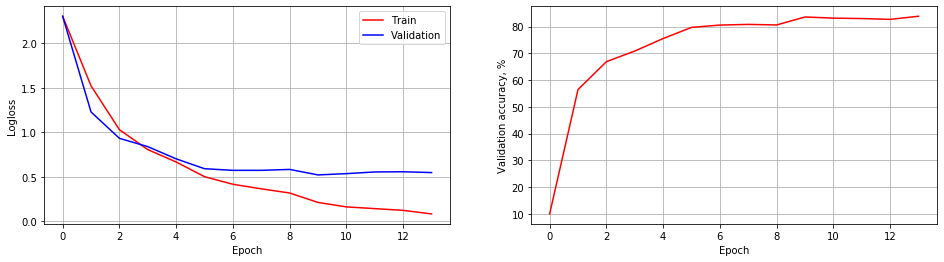

In [47]:
visualize_training([np.log(10)] + tr_res[0], [np.log(10)] + tr_res[1], [0.1] + tr_res[2])

#### Saving/loading model

In [48]:
torch.save(model_torch3.state_dict(), os.path.join('.', 'model_torch3_weights'))
#model_torch3.load_state_dict(torch.load(os.path.join('.', 'model_torch3_weights')))

#### Analyzing performance

Test set accuracy: 82.2%


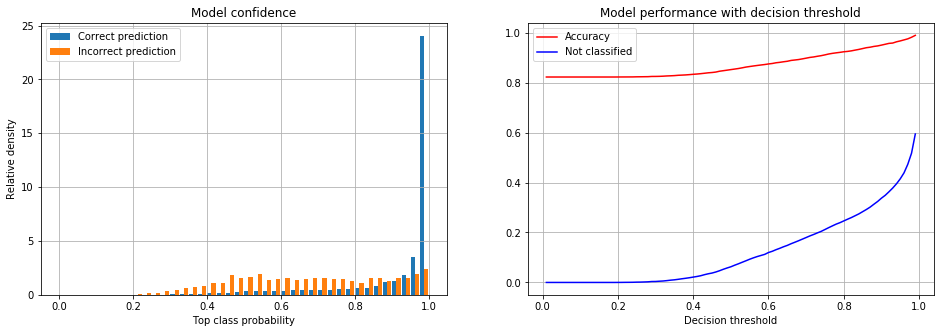

In [49]:
predX, gt, _ = predict_torch(model_torch3, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

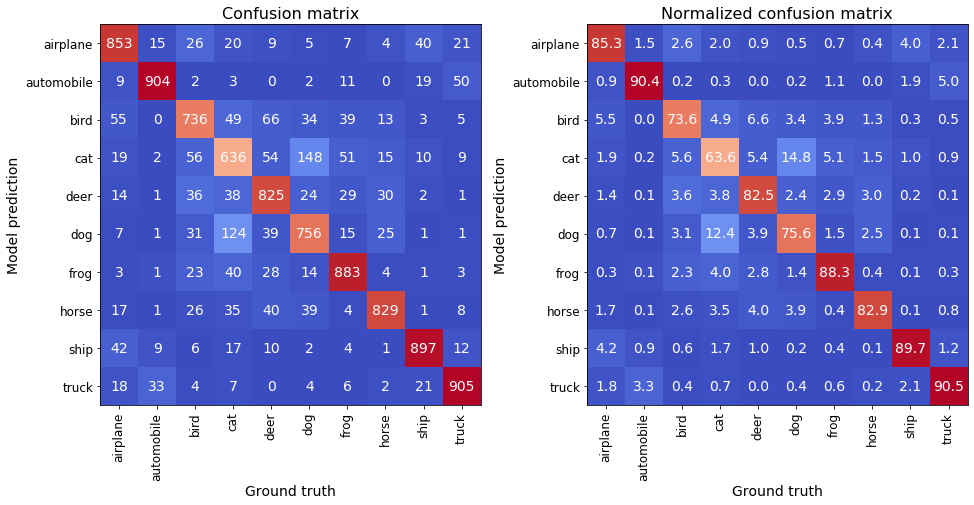

In [50]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories, 'coolwarm', 'white')

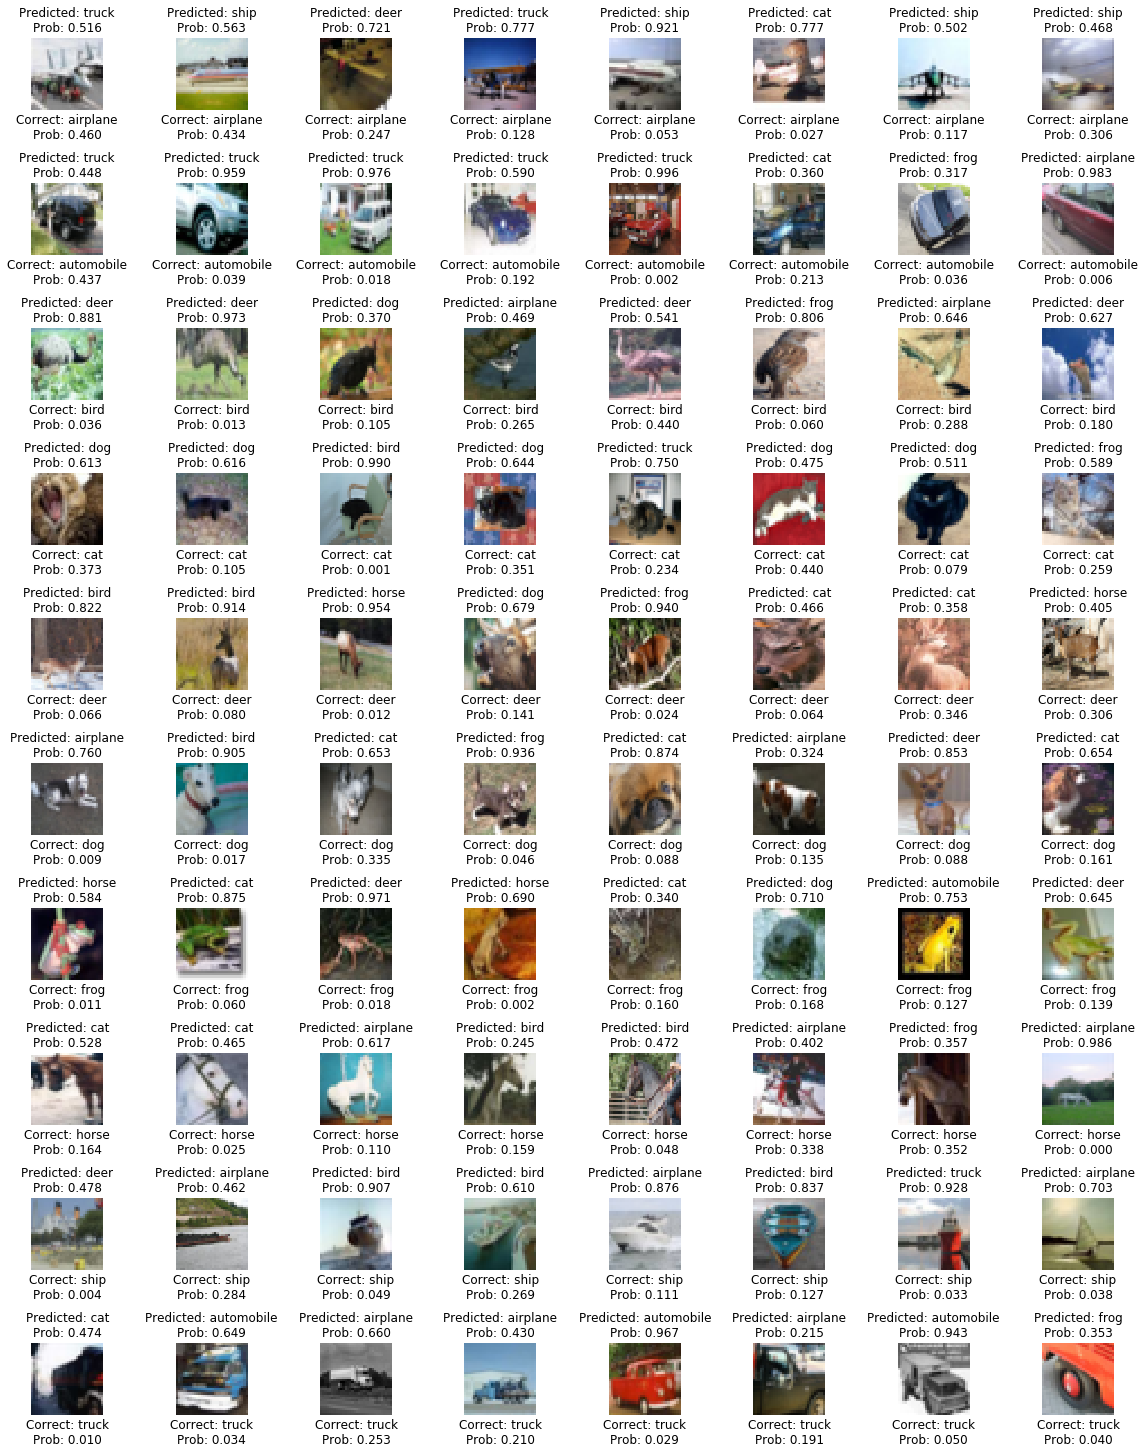

In [51]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 4.

In [53]:
class AugmentedCIFAR10(Dataset):
    def __init__(self, X, y, transformation=None):
        self.X = X
        self.y = y
        self.transformation = transformation
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        img = self.X[ix]
        
        if self.transformation:
            img = self.transformation(image=img)['image']
            
        return (torch.from_numpy(img), self.y[ix])

In [54]:
train_dset_aug = AugmentedCIFAR10(X_train0[train_idxs], y_train0[train_idxs], Compose([
    OneOf([
        Flip(p=0.5), Rotate(limit=20, p=0.5), 
    ]), 
    Rotate(limit=30, p=0.5), 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
]))

val_dset_aug = AugmentedCIFAR10(X_train0[val_idxs], y_train0[val_idxs], 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

test_dset_aug = AugmentedCIFAR10(X_test0, y_test0, 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

train_loader_aug = DataLoader(train_dset_aug, batch_size=2**7, 
                              sampler=RandomSampler(train_dset_aug))
val_loader_aug = DataLoader(val_dset_aug, batch_size=2**7, 
                            sampler=SequentialSampler(val_dset_aug))
test_loader_aug = DataLoader(test_dset_aug, batch_size=2**7, 
                             sampler=SequentialSampler(test_dset_aug))

### Hyperopt optimization

In [55]:
hp_torch4 = {
    'model': {
        'res_blocks': hp.choice('res_blocks', [1, 2, 3]), 
        'res_kernel': hp.choice('res_kernel', [3, 5]), 
        'downsampling': hp.choice('downsampling', ['maxpool', 'avgpool', 'conv']),  
        'start_channels': hp.choice('start_channels', [32, 48, 64]), 
        'out_channels_mult': hp.quniform('out_channels_mult', 1.0, 2.0, q=0.25), 
        'hid_channels_mult': hp.quniform('hid_channels_mult', 1.0, 2.0, q=0.25), 
        'drop_conv': hp.choice('drop_conv', [None, 
                                             hp.quniform('drop_convx', 0.05, 0.25, q=0.05)]), 
        'drop_linear': hp.choice('drop_linear', [None, 
                                                 hp.quniform('drop_linearx', 0.05, 0.5, q=0.05)])
    }, 
    'learning': {
        'lr_sch': hp.choice('lr_sch', [
            {
                'type': 'step_lr', 
                'pars': {
                    'step_size': 1 + hp.randint('s.step', 5), 
                    'gamma': hp.quniform('s.gamma', 0.3, 0.8, q=0.05), 
                }
            }, 
            {
                'type': 'cosine', 
                'pars': {
                    'T_max': hp.choice('c.T_max', [3, 4, 6, 8, 10, 15]), 
                    'eta_min': hp.loguniform('c.eta_min', -6.0*np.log(10), -5.0*np.log(10)), 
                }
            }, 
            {
                'type': 'plateau', 
                'pars': {
                    'factor': hp.quniform('p.gamma', 0.2, 0.8, q=0.05), 
                    'patience': hp.choice('p.patience', [2, 3, 4, 5]), 
                }
            }
        ]), 
        'opt': {
            'lr': hp.loguniform('lr', -4.0*np.log(10), -3.0*np.log(10)), 
            'weight_decay': hp.loguniform('reg', -4.0*np.log(10), -3.0*np.log(10))
        }
    }
}

In [56]:
def f_min(hps):
    model = TinyResNet(**hps['model'])
    model.type(torch.cuda.FloatTensor)
    model.to(GPU)
    
    loss_fct = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), **hps['learning']['opt'])
    
    if hps['learning']['lr_sch']['type'] == 'step_lr':
        lr_sch = torch.optim.lr_scheduler.StepLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'cosine':
        lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'plateau':
        lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 
            **hps['learning']['lr_sch']['pars'])
    
    tr_res = train_torch(model, GPU, train_loader_aug, val_loader_aug, 
                         loss_fct, opt, lr_sch, accuracy, 
                         num_epochs=30, verbose=False, show_progress=False, 
                         early_stopping=True, early_stopping_rounds=8, 
                         lr_plateau=(hps['learning']['lr_sch']['type'] == 'plateau'), 
                         delay=0)
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'loss': min(tr_res[1]), 
        'status': STATUS_OK, 
        'tr_hist': tr_res
    }

In [57]:
n_evals = 40
t_step = 5

try:
    with open(os.path.join(os.getcwd(), 'trials_2'), 'rb') as fh:
        trls = pickle.load(fh)
        print(f'Trials loaded, len: {len(trls)}')
except FileNotFoundError:
    trls = Trials()
    print('No trials found')
    
x_steps = len(trls)

while x_steps < n_evals:
    ho_torch4 = fmin(f_min, space=hp_torch4, algo=tpe.suggest, 
                     trials=trls, max_evals=x_steps + t_step, show_progressbar=True)
    x_steps += t_step
    with open(os.path.join(os.getcwd(), 'trials_2'), 'wb') as fh:
        pickle.dump(trls, fh)

Trials loaded, len: 40


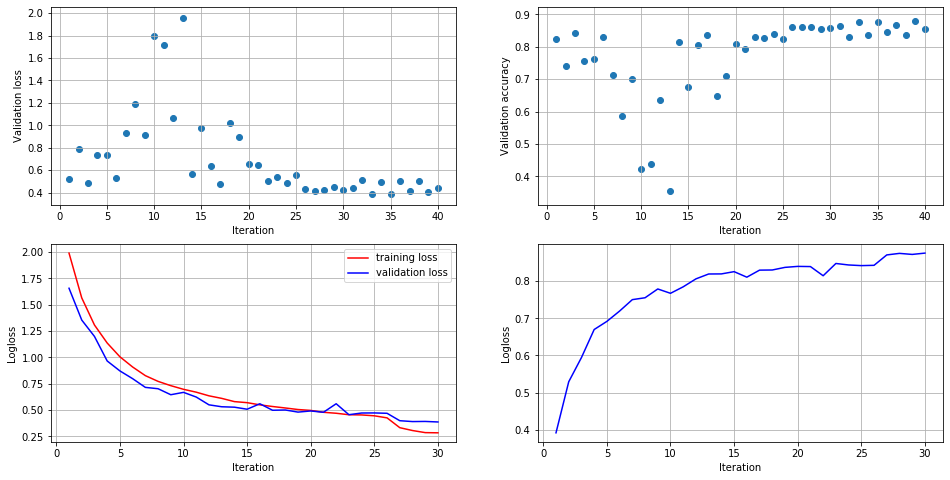

In [58]:
fig0, axs = plt.subplots(2, 2, figsize=(16, 8))

plt.sca(axs[0, 0])
plt.scatter(1 + np.arange(len(trls)), [x['result']['loss'] for x in trls.trials])
plt.xlabel('Iteration')
plt.ylabel('Validation loss')
plt.gca().grid(True)

plt.sca(axs[0, 1])
plt.scatter(1 + np.arange(len(trls)), [max(x['result']['tr_hist'][2]) for x in trls.trials])
plt.xlabel('Iteration')
plt.ylabel('Validation accuracy')
plt.gca().grid(True)

plt.sca(axs[1, 0])
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][0], 
         color='red', label='training loss')
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][1], 
         color='blue', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.gca().grid(True)
plt.legend()

plt.sca(axs[1, 1])
plt.plot(1 + np.arange(len(trls.best_trial['result']['tr_hist'][0])), 
         trls.best_trial['result']['tr_hist'][2], 
         color='blue')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.gca().grid(True)

### Model evaluation

In [69]:
best_params4 = space_eval(hp_torch4, {k: v[0] for (k, v) in 
                                      trls.best_trial['misc']['vals'].items() if len(v) > 0})
model_torch4 = TinyResNet(**best_params4['model'])

In [70]:
model_torch4.type(torch.cuda.FloatTensor)
model_torch4.to(GPU)

TinyResNet(
  (conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (resblock1): Sequential(
    (0): Bottleneck(
      (convblock): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (walkaround): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1)

In [73]:
#torch.save(model_torch4.state_dict(), os.path.join('.', 'model_torch4_weights'))
model_torch4.load_state_dict(torch.load(os.path.join('.', 'model_torch4_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Test set accuracy: 87.1%


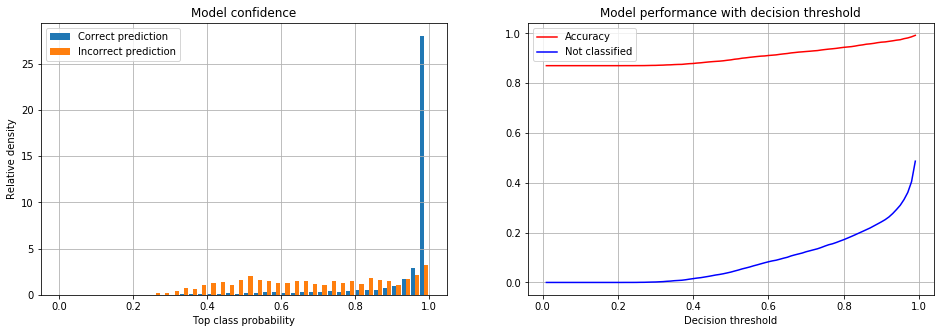

In [74]:
predX, gt, _ = predict_torch(model_torch4, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

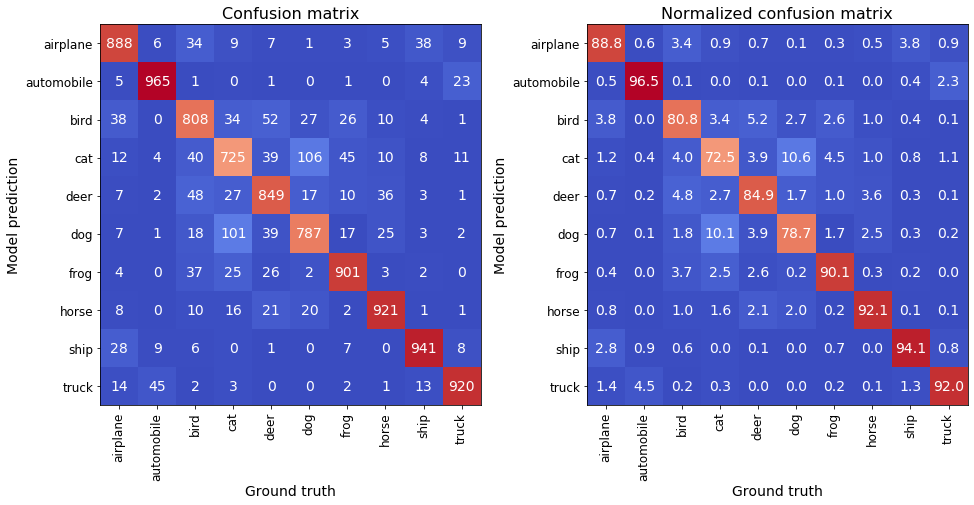

In [75]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories, 'coolwarm', 'white')

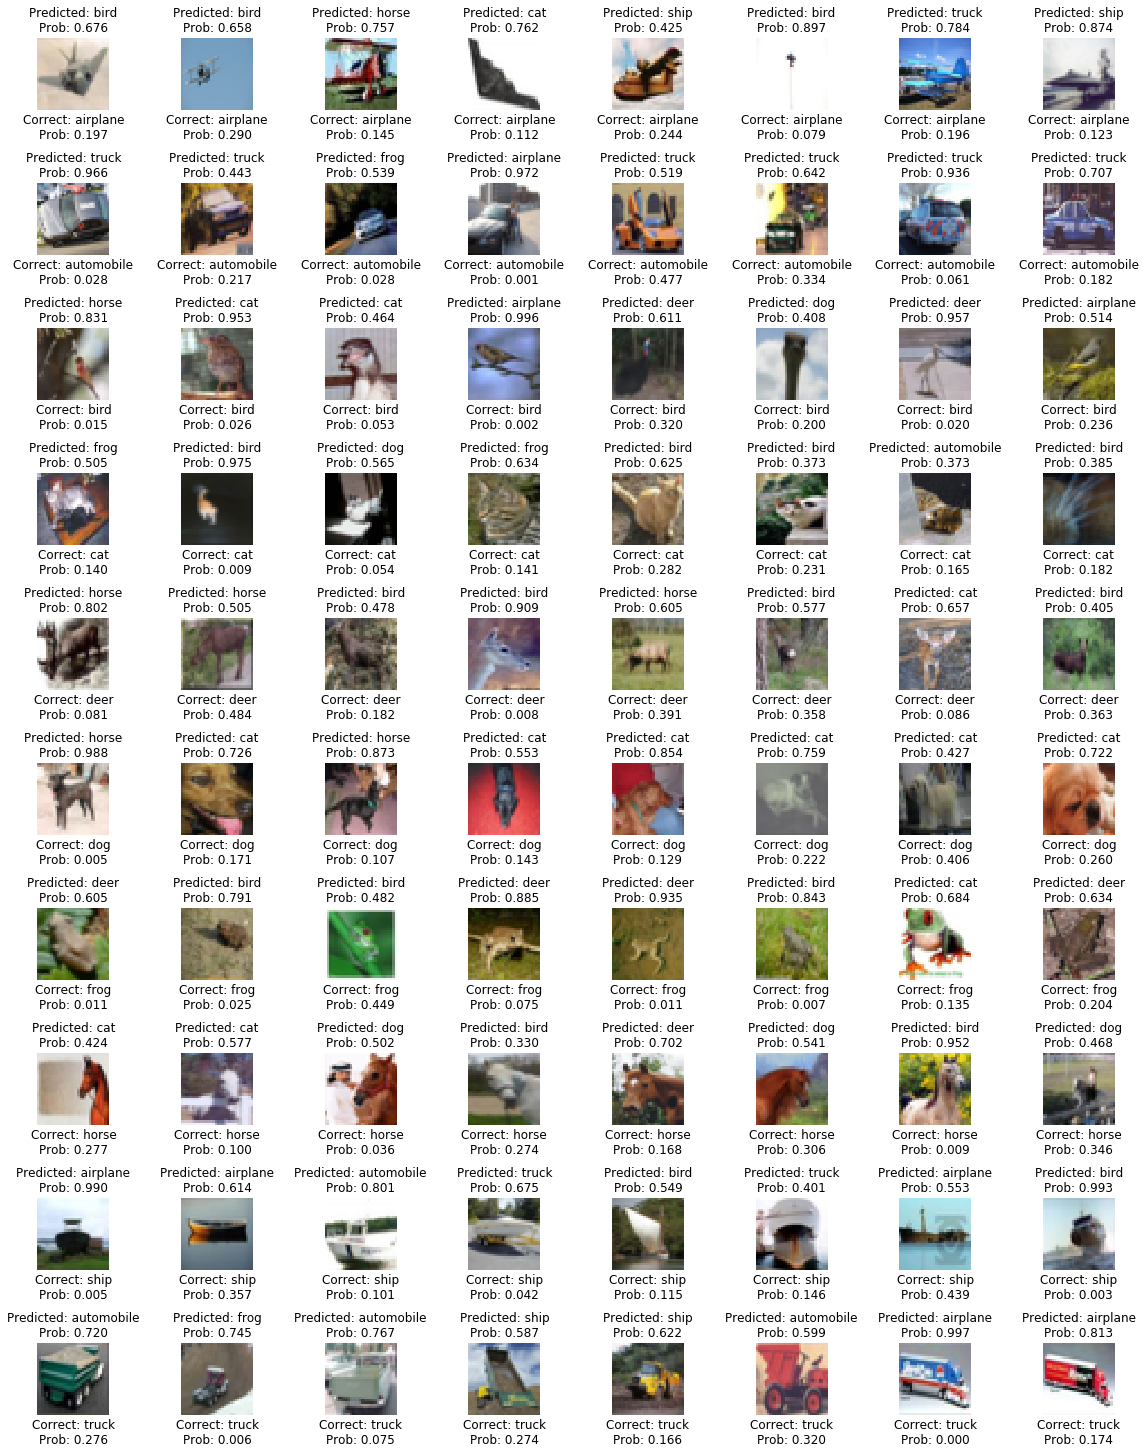

In [76]:
visualize_errors(predX, gt, X_test0, categories, 8)